# Training score-based diffusion model from first principles

In this part, we will walk step-by-step over the key steps of training a diffusion model.
The use-case here is to learn a diffusion model to generate a cloud of points that writes the word *"AI"*.

Later, we will leverage the labels of each point that indicate the letter to which it belongs to learn a conditional diffusion model capable of generating points distributed according to given letter.

The dataset is available in the folder ``assets/2D_data/``


## Exploring the dataset

In [1]:
import torch
import matplotlib.pyplot as plt

# load data
cloud_points = torch.load("assets/2D_data/cloud_points.pt")

# get the number of samples
cloud_points.shape

torch.Size([20000, 2])

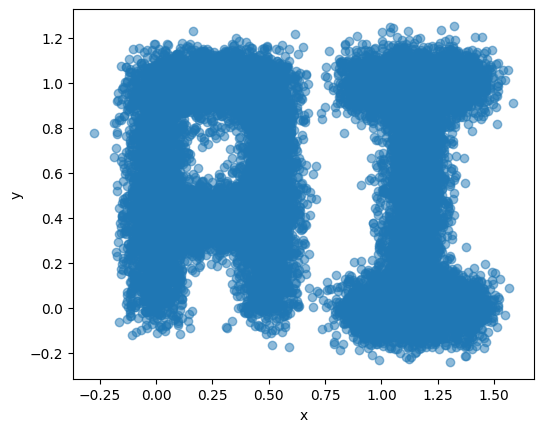

In [2]:
# plot cloud of points
fig, ax = plt.subplots()

ax.scatter(
    cloud_points[:, 0], cloud_points[:, 1], alpha=0.5
)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect(1)

**Note:**
For the analogy, in the case of a dataset of images, each point in the cloud of points will represent an image

## Forward process

Let's turn the dataset into a Gaussian distribution.
This can be described using a Markov process
$$
x_t  = \sqrt{\alpha}_t x_{t-1} + \sqrt{1 - \alpha_t} \varepsilon_t \\
x_0  \sim p_{data}, \quad
(\varepsilon_t)_t \overset{iid}{\sim} \mathcal{N}(0, I)
$$

We needn't to follow recurrently the chain $x_0 \rightarrow x_1 \rightarrow x_2 \rightarrow \dots \rightarrow x_t$ to get a sample $x_t$, we can jump directly from $x_0 \rightarrow x_t$

$$
x_t  = \sqrt{\bar{\alpha}}_t x_0 + \sqrt{1 - \bar{\alpha_t}} \epsilon_t, \quad
\bar{\alpha}_t = \textstyle \prod_k \alpha_k
$$

**Question**: Can you show it?


The sequence $\bar{\alpha}_t$ is the so called **noise scheduler**.

Let's import linear scheduler an see what it does.
It is available in the provided code in under ``py_code/diffusion.py``.

**Solution:**

We can show this by recursively applying the Markov process definition. Starting from $x_0$:

$$x_1 = \sqrt{\alpha_1} x_0 + \sqrt{1 - \alpha_1} \varepsilon_1$$

For $x_2$, we substitute $x_1$:

$$x_2 = \sqrt{\alpha_2} x_1 + \sqrt{1 - \alpha_2} \varepsilon_2$$

$$x_2 = \sqrt{\alpha_2} \left(\sqrt{\alpha_1} x_0 + \sqrt{1 - \alpha_1} \varepsilon_1\right) + \sqrt{1 - \alpha_2} \varepsilon_2$$

$$x_2 = \sqrt{\alpha_2 \alpha_1} x_0 + \sqrt{\alpha_2(1 - \alpha_1)} \varepsilon_1 + \sqrt{1 - \alpha_2} \varepsilon_2$$

Since $\varepsilon_1$ and $\varepsilon_2$ are independent standard normal random variables, their linear combination is also normal. Specifically, if $Z_1, Z_2 \sim \mathcal{N}(0, I)$ are independent, then:

$$\sqrt{\alpha_2(1 - \alpha_1)} Z_1 + \sqrt{1 - \alpha_2} Z_2 \sim \mathcal{N}(0, \alpha_2(1 - \alpha_1) + (1 - \alpha_2)) = \mathcal{N}(0, 1 - \alpha_2 \alpha_1)$$

Therefore, we can write:

$$x_2 = \sqrt{\alpha_2 \alpha_1} x_0 + \sqrt{1 - \alpha_2 \alpha_1} \epsilon_2$$

where $\epsilon_2 \sim \mathcal{N}(0, I)$.

Continuing this process recursively, we get:

$$x_t = \sqrt{\prod_{k=1}^t \alpha_k} x_0 + \sqrt{1 - \prod_{k=1}^t \alpha_k} \epsilon_t$$

Defining $\bar{\alpha}_t = \prod_{k=1}^t \alpha_k$, we obtain:

$$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon_t$$

where $\epsilon_t \sim \mathcal{N}(0, I)$.


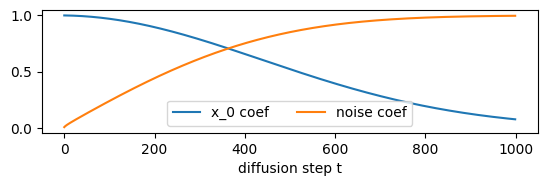

In [3]:
# let's plot the scheduler
from assets.py_code.diffusion import linear_schedule

n_diffusion_steps = 1000
alphas_cumprod = linear_schedule(n_diffusion_steps)


fig, ax = plt.subplots()

ax.plot(alphas_cumprod.sqrt(), label="x_0 coef")
ax.plot((1 - alphas_cumprod).sqrt(), label="noise coef")

ax.set_xlabel("diffusion step t")
ax.set_aspect(250)
ax.legend(loc="lower center", ncols=2)

**Question**: Can you comment this figure? what happens to the $x_0$ and the noise as the time evolve ?

**Summary of what the visualization shows:**

The figure clearly demonstrates that:
- **Noise coefficient ($\sqrt{1 - \bar{\alpha}_t}$) increases** as $t$ increases
- **$x_0$ coefficient ($\sqrt{\bar{\alpha}_t}$) decreases** as $t$ increases

This is the expected behavior: as the diffusion process progresses, the signal from the original data $x_0$ fades away while noise gradually dominates, eventually transforming $x_t$ into pure Gaussian noise.


**Breakdown:**

The figure shows how the coefficients $\sqrt{\bar{\alpha}_t}$ (for $x_0$) and $\sqrt{1 - \bar{\alpha}_t}$ (for the noise) evolve as the diffusion step $t$ increases.

**Key observations:**

1. **$x_0$ coefficient ($\sqrt{\bar{\alpha}_t}$)**: 
   - Starts at 1 when $t=0$ (no noise added yet, $x_0 = x_0$)
   - **Decreases monotonically** as $t$ increases
   - Approaches 0 as $t$ approaches the maximum number of diffusion steps
   - This means the contribution of the original data $x_0$ to $x_t$ becomes weaker over time

2. **Noise coefficient ($\sqrt{1 - \bar{\alpha}_t}$)**:
   - Starts at 0 when $t=0$ (no noise initially)
   - **Increases monotonically** as $t$ increases
   - Approaches 1 as $t$ approaches the maximum number of diffusion steps
   - This means the contribution of the noise $\epsilon_t$ to $x_t$ becomes stronger over time

3. **Relationship**: 
   - The two curves are complementary: $\sqrt{\bar{\alpha}_t}^2 + \sqrt{1 - \bar{\alpha}_t}^2 = \bar{\alpha}_t + (1 - \bar{\alpha}_t) = 1$
   - As one increases, the other decreases, maintaining the variance structure of the diffusion process

**Interpretation:**
As time evolves, the forward diffusion process gradually transforms the data distribution into a pure Gaussian noise distribution. At early steps, $x_t$ is mostly composed of the original data $x_0$ with a small amount of noise. As $t$ increases, the signal from $x_0$ fades away and is replaced by noise, until eventually $x_t$ becomes essentially pure noise from $\mathcal{N}(0, I)$.


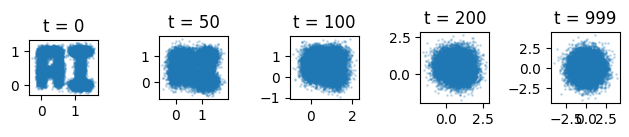

In [4]:

selected_time = [0, 50, 100, 200, 999]

fig, axes = plt.subplots(ncols=len(selected_time),)

for ax, t in zip(axes, selected_time):
    acp_t = alphas_cumprod[t]
    noise = torch.randn_like(cloud_points)

    x_t = acp_t.sqrt() * cloud_points + (1 - acp_t).sqrt() * noise

    ax.scatter(x_t[:, 0], x_t[:, 1], s=1, alpha=0.2)
    ax.set_title(f"{t = }")
    ax.set_aspect(1)

fig.tight_layout()

## Learning a Denoising Diffusion Probabilistic Model (DDPM) 


We want to learn a noise predictor
$$
\epsilon_{\theta}(x_t, t)
$$
given an $x_t$, it predict the noise that was added to $x_0$.

We model the noise predictor as a Neural Network.

Notice that we have to learn a NN that depends on time.
Therefore, we need a way to embed the information of time in it.
We achieve that using positional encoding.

Let's learn a simple MLP to predict the added noise.
For positional encoding, we will learn a table of vector, where each vector is an embedding of a time step. 

We will implement this architecture

<img src="./illustrations/architecutre.png" />

In [5]:
import torch
from torch import nn


class EpsilonNet(nn.Module):

    def __init__(self, d_encoding=20, n_blocks=5, n_diffusion_steps=50):
        super().__init__()

        self.d_encoding = d_encoding
        self.n_blocks = n_blocks
        self.n_diffusion_steps = n_diffusion_steps

        self.position_encoder = nn.Embedding(
            embedding_dim=self.d_encoding, num_embeddings=n_diffusion_steps
        )

        self.encoder = nn.Sequential(
            nn.Linear(2, self.d_encoding),
            nn.BatchNorm1d(self.d_encoding),
        )

        layers = [BlockMLP(d_encoding, d_encoding) for _ in range(n_blocks)]
        self.network = nn.Sequential(*layers)

        self.decoder = nn.Sequential(
            nn.Linear(self.d_encoding, 2),
            nn.BatchNorm1d(2)
        )

    def forward(
        self, noisy_points: torch.Tensor, t: int | torch.Tensor
    ) -> torch.Tensor:

        out = self.encoder(noisy_points) + self.position_encoder(t)
        out = self.network(out)
        out = self.decoder(out)

        return out


class BlockMLP(nn.Module):

    def __init__(self, in_features, out_features):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.ReLU(),
            nn.BatchNorm1d(out_features),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)


**Architecture Description:**

The `EpsilonNet` architecture is designed to predict the noise $\epsilon_\theta(x_t, t)$ that was added to the original data $x_0$ to obtain the noisy version $x_t$ at timestep $t$. The architecture consists of:

1. **Input Layer**: Takes noisy 2D points $x_t$ and timestep $t$ as inputs

2. **Position Encoder**: An embedding layer that encodes the timestep $t$ into a $d_{encoding}$-dimensional vector. This allows the network to condition its predictions on the diffusion timestep.

3. **Input Encoder**: A linear layer followed by batch normalization that projects the 2D input points to the $d_{encoding}$-dimensional space.

4. **Feature Fusion**: The encoded input points and position encoding are added together (element-wise addition) to create a combined representation.

5. **Network Blocks**: A sequence of $n_{blocks}$ `BlockMLP` layers, where each block consists of:
   - Linear layer
   - ReLU activation
   - Batch normalization
   
   These blocks process the combined features through multiple layers of non-linear transformations.

6. **Decoder**: A linear layer followed by batch normalization that projects the processed features back to 2D space, outputting the predicted noise.

**Key Design Choices:**
- The timestep information is incorporated via **additive positional encoding**, allowing the network to learn different denoising behaviors for different diffusion steps
- The architecture uses **batch normalization** throughout to stabilize training
- The network maintains the same dimensionality ($d_{encoding}$) through the intermediate layers, with only the input and output layers handling the 2D point space


We can show that training a diffusion models reduces to minimizes the following loss

$$
\hat{\theta} = \arg\min_\theta \ \mathbb{E}_{x_0, t, \epsilon} \| \epsilon - \epsilon_{\theta}(x_t, t) \|^2
$$

This is the training objective for a diffusion model. It minimizes the mean squared error between the true noise $\epsilon$ and the predicted noise $\epsilon_\theta(x_t, t)$.

$x_0$: original data sample
$t$: random timestep from the diffusion process
$\epsilon$: noise added to create $x_t = \sqrt{\bar{\alpha}t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$
$\epsilon_\theta(x_t, t)$: network prediction of the noise given the noisy input $x_t$ and timestep $t$
By learning to predict the noise at each timestep, the model learns to reverse the forward diffusion process, enabling generation of new samples from noise.

Let's train the model for 1000 epoch using Adam optimizer with learning rate of ``lr=0.01``.

**Question**: from the code below, what are the other tweaks used for training the model?


Beyond the Adam optimizer and learning rate of 0.01, the code uses several training tweaks:

1. **Learning Rate Scheduling**: `CosineAnnealingLR` scheduler that gradually decreases the learning rate following a cosine annealing schedule from the initial learning rate down to `lr/100` over `n_epochs` iterations. This helps the model converge more smoothly and find better minima.

2. **Random Timestep Sampling**: For each batch, random timesteps are sampled using `torch.randint(low=0, high=n_diffusion_steps)`. This ensures the model learns to denoise at all diffusion steps, not just specific ones, which is crucial for the reverse diffusion process.

3. **Data Shuffling**: The `DataLoader` uses `shuffle=True`, which randomizes the order of data samples in each epoch, helping prevent overfitting and improving generalization.

4. **Gradient Management**: `optimizer.zero_grad()` is called before each backward pass to clear previous gradients, preventing gradient accumulation across batches.



These techniques work together to stabilize training and ensure the model learns effective denoising across all timesteps of the diffusion process.


In [6]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

device = "cpu"

data_loader = DataLoader(cloud_points, batch_size=len(cloud_points) // 10, shuffle=True)

n_diffusion_steps = 1000
n_epochs = 1000
lr = 1e-2

alphas_cumprod = linear_schedule(n_diffusion_steps)
alphas_cumprod = alphas_cumprod.to(device)

eps_net = EpsilonNet(d_encoding=20, n_blocks=5, n_diffusion_steps=n_diffusion_steps)
eps_net.to(device)
eps_net.train()

optimizer = Adam(eps_net.parameters(), lr)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=lr / 100)


for epoch in (tbar := tqdm(range(n_epochs))):

    for batch_points in data_loader:

        optimizer.zero_grad()

        batch_points = batch_points.to(device)
        timesteps = torch.randint(
            size=(len(batch_points),),
            low=0,
            high=n_diffusion_steps,
            device=device
        )
        noise = torch.randn_like(batch_points, device=device)

        # noise the data
        acp_t = alphas_cumprod[timesteps][:, None]
        x_t = acp_t.sqrt() * batch_points + (1 - acp_t).sqrt() * noise

        # predict the added noise
        predicted_noise = eps_net(x_t, timesteps)

        # backprop the error
        loss = torch.norm(predicted_noise - noise) ** 2
        loss.backward()

        optimizer.step()
        tbar.set_description(f"loss per batch = {loss.item():.8f}")

    lr_scheduler.step()


loss per batch = 807.98706055: 100%|██████████| 1000/1000 [00:59<00:00, 16.94it/s]


is the squared L2 norm (MSE) between predicted and actual noise. High loss , suggests either:
A larger batch size (e.g., ~380 samples would give ~760)
, The model hasn't fully converged yet
, The loss is still decreasing

Now that, we trained the model let set it to inference mode

In [7]:
eps_net.eval()
eps_net.requires_grad_(False);

Check the training by plotting the vector field defined by score.

Recall that the score $s_{\theta}(x_t, t) = \nabla \log p_t(x_t)$ is linked to the the noise predictor by

$$
s_{\theta}(x_t, t) = - \sqrt{1 - \bar{\alpha}_t} \epsilon_\theta(x_t, t)
,
$$


/Users/sarasaad/Documents/BDMA /CentraleSupelec/Deep Learning/DiffusionModels/.venv/lib/python3.11/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4319.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


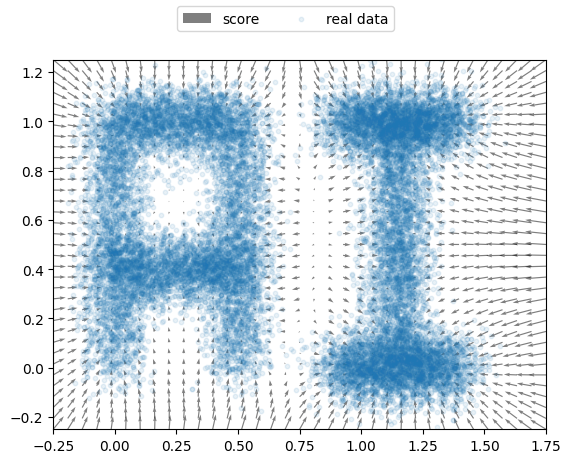

In [8]:
from assets.py_code.diffusion import plot_score_vector_field

# implement a function to compute it
def score(eps_net, x_t, t):
    pred_noise = eps_net(x_t, t)
    return -pred_noise / (1 - alphas_cumprod[t]).sqrt()


# plot the gradient field of the score
fig, ax = plt.subplots()

t = 10

# define grid
n_x_points = n_y_points = 35
x_lim = (-0.25, 1.75)
y_lim = (-0.25, 1.25)
x_range = torch.linspace(*x_lim, n_x_points)
y_range = torch.linspace(*y_lim, n_y_points)

# plot the score vector
score_func = lambda x_t, t: score(eps_net, x_t, t)
plot_score_vector_field(score_func, t, x_range, y_range, device, ax)

# plot cloud of point as reference
ax.scatter(cloud_points[:, 0], cloud_points[:, 1], alpha=0.1, label="real data", s=10)

# layout for beautiful plots
ax.set_xlim(*x_lim)
ax.set_ylim(*y_lim)
ax.set_aspect(1)

fig.legend(loc="upper center", ncols=2)

## Generating new samples

A straight forward way to generate new sample is to simulate backward in time the markov chain.

This is commonly referred to as *ancestral sampling* [1].


<img src="./illustrations/sampling_algo.png" />

.. [1] Ho, Jonathan, Ajay Jain, and Pieter Abbeel.
    "Denoising diffusion probabilistic models."
    Advances in neural information processing systems 33 (2020): 6840-6851.

**Simple Explanation:**

**Ancestral sampling** is how you generate new samples from a trained diffusion model.

**The idea:**
1. **Start with pure noise**: Begin with random Gaussian noise (like static on a TV screen)
2. **Run the process backwards**: Use your trained model to remove noise step-by-step, going backwards through the diffusion process
3. **End with a clean sample**: After enough steps, you get a clean sample that looks like your training data

**Why "ancestral"?**
- During training, we go **forward**: data → noise (adding noise over time)
- During generation, we go **backward**: noise → data (removing noise step-by-step)
- "Ancestral" refers to tracing back through the steps to recover the original-like sample

**In practice:**
- Start with random noise $x_T$
- Use the trained model to predict and remove noise at each step
- Go from $x_T$ → $x_{T-1}$ → $x_{T-2}$ → ... → $x_0$
- The final $x_0$ is your generated sample

It's like watching a video of a painting being destroyed in reverse—you start with a mess and gradually reveal the image!


In [9]:
# Implement a function to perform ancestral sampling

def ancestral_sampling(initial_noise: torch.Tensor):
    device = initial_noise.device
    x_t = initial_noise

    for t in reversed(range(1, n_diffusion_steps)):
        t = torch.tensor(t, device=device)
        t_prev = t - 1
        pred_noise = eps_net(x_t, t)

        acp_t, acp_t_prev = alphas_cumprod[t], alphas_cumprod[t_prev]
        alpha_t = acp_t / acp_t_prev

        sigma_t = torch.sqrt((1 - acp_t_prev) / (1 - acp_t) * (1 - alpha_t))
        coef_pred_noise = (1 - alpha_t) / (1 - acp_t).sqrt()

        noise = torch.randn_like(x_t, device=device)
        x_t = (x_t - coef_pred_noise * pred_noise) / alpha_t.sqrt() + sigma_t * noise

    return x_t

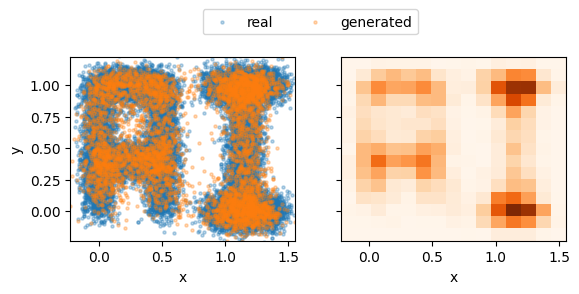

In [10]:
# generate new samples
n_samples = 5_000
initial_noise = torch.randn((n_samples, 2), device=device)
generated_points = ancestral_sampling(initial_noise)
generated_points = generated_points.cpu()

# plot generated vs. real
# make a second plot of the histogram of the generated points
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
ax = axes[0]
for points, label in zip((cloud_points, generated_points), ("real", "generated")):
    p = points.cpu()
    ax.scatter(p[:, 0], p[:, 1], label=label, alpha=0.3, s=5)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect(1)

ax = axes[1]
ax.hist2d(generated_points[:, 0], generated_points[:, 1], bins=15, cmap="Oranges")
ax.set_xlabel("x")
ax.set_aspect(1)

fig.legend(loc="upper center", ncol=2,  bbox_to_anchor=(0.5, 0.8))


**Summary so far:**


**What we already did (Ancestral Sampling):**
- Goes through **ALL** diffusion steps (e.g., 1000 steps: T → T-1 → T-2 → ... → 0)
- Is **stochastic** (adds random noise at each step: `noise = torch.randn_like(x_t)`)
- Slower but follows the exact training process

**What DDIM offers:**
- Can **skip steps** (e.g., only do every 10th step: T → T-10 → T-20 → ... → 0)
- Can be **deterministic** (no random noise, same noise → same output)
- Much faster while maintaining quality

So DDIM is an **improvement** over ancestral sampling - it's faster and can be deterministic, which is useful for tasks like image editing where you want reproducible results.


Here we will answer the question Can we skip some of diffusion steps? and if so, to which extent we can do that.

This is possible thanks to DDIM sampling [1].

It is also possible to remove the stochastisticity in-between diffusion steps.
Hence, we obtain a direct mapping from samples of the dataset and samples from the normal distribution.


.. [1] Song, Jiaming, Chenlin Meng, and Stefano Ermon.
    "Denoising diffusion implicit models." arXiv preprint arXiv:2010.02502 (2020).


In [11]:
# implement DDIM sampling
from assets.py_code.diffusion import ddim_statistics


def ddim_sampling(n_steps: int, n_samples: int = 5_000, eta: float = 1):
    timesteps = torch.arange(
        0, n_diffusion_steps, step=n_diffusion_steps // n_steps, device=device
    )
    reversed_timesteps = timesteps.flip(0)

    x_t = torch.randn((n_samples, 2), device=device)
    for t, t_prev in zip(reversed_timesteps[:-1], reversed_timesteps[1:]):
        coef_x_t, coef_x_0, std = ddim_statistics(t, t_prev, alphas_cumprod, eta=eta)

        acp_t = alphas_cumprod[t]
        pred_noise = eps_net(x_t, t)
        pred_x_0 = (x_t - (1 - acp_t).sqrt() * pred_noise) / acp_t.sqrt()

        noise = torch.randn_like(x_t)
        x_t = coef_x_t * x_t + coef_x_0 * pred_x_0 + std * noise

    return x_t

Let's see the impact of reducing the number of diffusion steps on the quality of the generated data

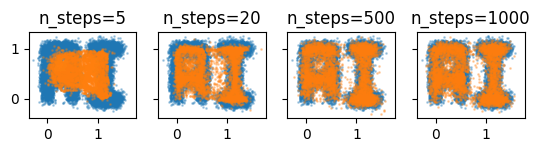

In [12]:

list_n_steps = [5, 20, 500, 1000]
fig, axes = plt.subplots(1, len(list_n_steps), sharey=True, sharex=True)

for ax, n_steps in zip(axes, list_n_steps):

    generated_points = ddim_sampling(n_steps, eta=0.5)

    ax.set_title(f"{n_steps=}")
    for points, label in zip((cloud_points, generated_points), ("real", "generated")):
        p = points.cpu()
        ax.scatter(p[:, 0], p[:, 1], label=label, alpha=0.3, s=1)
    ax.set_aspect(1)


**Why more steps lead to clearer results:**

The relationship between the number of sampling steps and output quality:

1. **Gradual refinement**: Each denoising step makes a small correction. More steps allow finer, more accurate corrections, reducing accumulated errors.

2. **Better approximation**: The model was trained on the full diffusion process (1000 steps). Using fewer steps is an approximation—the model must "jump" larger gaps between timesteps, which can introduce errors.

3. **Error accumulation**: With fewer steps, each step must remove more noise. Small prediction errors compound, leading to artifacts or blurriness.

4. **Training-test mismatch**: If the model was trained to denoise at specific timesteps (e.g., t=999, t=998, ...), skipping steps means using the model at timesteps it hasn't seen during training, reducing accuracy.

**Trade-off**: More steps = better quality but slower generation. DDIM allows finding a balance—using fewer steps (e.g., 50-100) while maintaining reasonable quality, making it much faster than full ancestral sampling (1000 steps).

## Extension to conditional diffusion models

Provided that we have an additional information about to which letter a point belongs, we would like to learn a conditional model that generate according to the distribution of one letter: Generate points distributed according to the letter "A" (or "I").

Classifier free guidance [1] is a framework to train diffusion models that enables to account for a context.

It consist of training a network that takes an additional context

$$
\epsilon_{\theta}(x_t, t, c)
$$

where c is a context.
The context c can be empty.
In this case, the network behaves as if it were unconditioned.


.. [1] Ho, Jonathan, and Tim Salimans.
    "Classifier-free diffusion guidance." arXiv preprint arXiv:2207.12598 (2022).

As long as we are able to embed the context in a *suitable* space, we can inject the context in the network and learn to perform conditional generation.

For the analogy, the context might be text (caption of an image), hence we could use a text encoder to inject it into the network. 

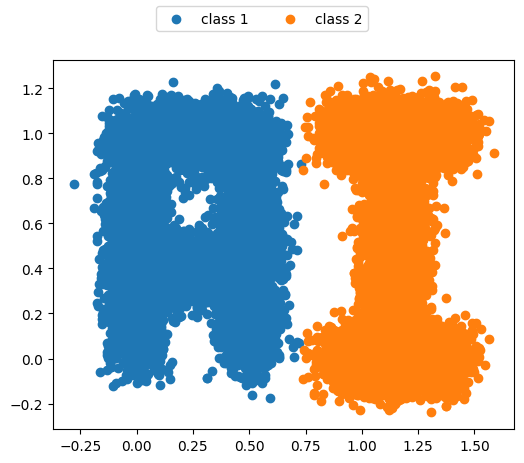

In [13]:
# load the labels
labels_points = torch.load("assets/2D_data/cloud_points_labels.pt")

# plot to find out the label of each letter
fig, ax = plt.subplots()

for idx in (1, 2):
    points = cloud_points[labels_points == idx]
    ax.scatter(points[:, 0], points[:, 1], label=f"class {idx}")

ax.set_aspect(1)
fig.legend(loc="upper center", ncols=2)

Let us modify the network to inject the information of the letters.
Since we have two classes, we will learn to vectors to embed the each class.

We will use the class index 0 to represent *"no context"*.

Let's implement the following architecture

<img src="./illustrations/architecture_with_context.png"/>


Notice that it is the same as the previous architecture with the exception of injecting context into the network

In [14]:

class EpsilonNetConditional(nn.Module):

    def __init__(self, d_encoding=20, n_blocks=5, n_diffusion_steps=50, n_classes=2):
        super().__init__()

        self.d_encoding = d_encoding
        self.n_blocks = n_blocks
        self.n_diffusion_steps = n_diffusion_steps

        self.position_encoder = nn.Embedding(
            embedding_dim=self.d_encoding, num_embeddings=n_diffusion_steps
        )
        # NOTE set the index 0 to represent "no context"
        # we will be a static zero vector
        self.class_encoder = nn.Embedding(
            embedding_dim=self.d_encoding, num_embeddings=n_classes + 1, padding_idx=0
        )

        self.encoder = nn.Sequential(
            nn.Linear(2, self.d_encoding),
            nn.BatchNorm1d(self.d_encoding),
        )

        layers = [BlockMLP(d_encoding, d_encoding) for _ in range(n_blocks)]
        self.network = nn.Sequential(*layers)

        self.decoder = nn.Sequential(
            nn.Linear(self.d_encoding, 2),
            nn.BatchNorm1d(2)
        )

    def forward(
        self, noisy_points: torch.Tensor, t: int | torch.Tensor, c: int | torch.Tensor
    ) -> torch.Tensor:
        # cast `t` (or `c`) to tensor if provided as integers
        if isinstance(t, int):
            t = torch.tensor(t, device=noisy_points.device)
        if isinstance(c, int):
            c = torch.tensor(c, device=noisy_points.device)

        out = self.encoder(noisy_points) + self.position_encoder(t) + self.class_encoder(c)
        out = self.network(out)
        out = self.decoder(out)

        return out

The training loss very similar to the loss used in the unconditional training

$$
\hat{\theta} = \arg\min_\theta \ \mathbb{E}_{(x_0, c), t, \epsilon} \| \epsilon - \epsilon_{\theta}(x_t, t, c) \|^2
$$

where we include the possibility of the context being $c = \empty$ to mean unconditional denoising. 

**Solution:**

The model trains **20% of the time** (or with probability 0.2) with context.

Looking at the code:
- `prob_context_train = 0.2` sets the probability to 0.2 (20%)
- `ctx_mask = torch.rand(size=(batch_size,), device=device) < prob_context_train` creates a boolean mask that is `True` approximately 20% of the time
- `context = batch_labels * ctx_mask` means:
  - When `ctx_mask` is `True` (20% of the time): `context = batch_labels` (conditional training)
  - When `ctx_mask` is `False` (80% of the time): `context = 0` (unconditional training)

**Why this approach?**

This is called **classifier-free guidance** training. By training the same model both conditionally (20% of the time) and unconditionally (80% of the time), you can:
1. Generate samples with or without context
2. Use guidance during inference to control generation strength
3. Achieve better quality conditional generation through guidance

The 20/80 split is a common choice - you want enough conditional training to learn the context, but also enough unconditional training to have a good baseline model.


**Question:** From the code below, how many times with train with a context?

In [15]:
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

device = "cpu"

data = TensorDataset(cloud_points, labels_points)
data_loader = DataLoader(data, batch_size=len(cloud_points) // 10, shuffle=True)

n_diffusion_steps = 1000
n_classes = 2
n_epochs = 1000
lr = 1e-2

alphas_cumprod = linear_schedule(n_diffusion_steps)
alphas_cumprod = alphas_cumprod.to(device)

eps_net_c = EpsilonNetConditional(
    d_encoding=20, n_blocks=5, n_diffusion_steps=n_diffusion_steps, n_classes=n_classes
)
eps_net_c.to(device)
eps_net_c.train()

optimizer = Adam(eps_net_c.parameters(), lr)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=lr / 100)


prob_context_train = 0.2
for epoch in (tbar := tqdm(range(n_epochs))):

    for batch_points, batch_labels in data_loader:

        optimizer.zero_grad()
        batch_size = len(batch_points)

        batch_points = batch_points.to(device)
        batch_labels = batch_labels.to(device)

        # train conditionally with probability `prob_context_train`
        ctx_mask = torch.rand(size=(batch_size,), device=device) < prob_context_train
        context = batch_labels * ctx_mask

        # draw randomly diffusion steps and noise
        timesteps = torch.randint(
            size=(batch_size,),
            low=0,
            high=n_diffusion_steps,
            device=device
        )
        noise = torch.randn_like(batch_points, device=device)

        # noise the data
        acp_t = alphas_cumprod[timesteps][:, None]
        x_t = acp_t.sqrt() * batch_points + (1 - acp_t).sqrt() * noise

        # predict the added noise
        predicted_noise = eps_net_c(x_t, timesteps, context)

        # backprop the error
        loss = torch.norm(predicted_noise - noise) ** 2
        loss.backward()

        optimizer.step()
        tbar.set_description(f"loss per batch = {loss.item():.8f}")

    lr_scheduler.step()


loss per batch = 748.43414307: 100%|██████████| 1000/1000 [01:38<00:00, 10.17it/s]


In [16]:
# set the network to inference model
eps_net_c.eval()
eps_net_c.requires_grad_(False);

Conditional sampling is also similar to unconditional sampling.
We introduce a hyperparameter to control the amount of guidance and use as noise predictor

$$
\tilde{\epsilon}_{\theta}(x_t, t, c) = (1 + w) \epsilon_{\theta}(x_t, t, c) - w \epsilon_{\theta}(x_t, t, c=\empty)
$$

Notice for instance when $w=-1$ it becomes unconditional sampling.

In [17]:
# implement sampling with classifier-free guidance

def sample_cls_free(n_samples: int, context: int = 0, w: float = 0.):
    n_samples = 5_000
    x_t = torch.randn((n_samples, 2), device=device)

    for t in reversed(range(1, n_diffusion_steps)):
        t = torch.tensor(t, device=device)
        t_prev = t - 1
        pred_noise = (1 + w) * eps_net_c(x_t, t, context) - w * eps_net_c(x_t, t, c=0)

        acp_t, acp_t_prev = alphas_cumprod[t], alphas_cumprod[t_prev]
        alpha_t = acp_t / acp_t_prev

        sigma_t = torch.sqrt((1 - acp_t_prev) / (1 - acp_t) * (1 - alpha_t))
        coef_pred_noise = (1 - alpha_t) / (1 - acp_t).sqrt()

        noise = torch.randn_like(x_t)
        x_t = (x_t - coef_pred_noise * pred_noise) / alpha_t.sqrt() + sigma_t * noise

    return x_t


For comparison, let us make a plot with three subplots
- 1st: sample with context "I"
- 2nd: sample with context "A"
- 3rd: sample unconditionally

and compare with the real data.

In a second row of the plot, let's plot the histogram of the generated points.

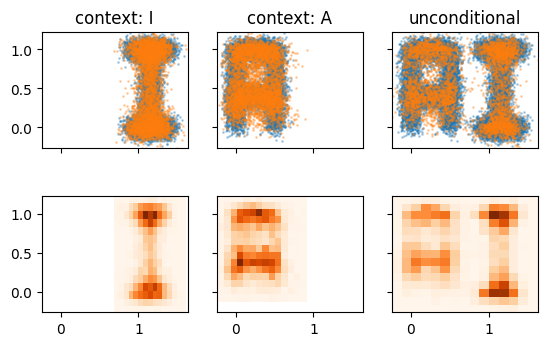

In [18]:
fig, axes = plt.subplots(2, 3, sharey=True, sharex=True)

list_context = [(2, "context: I"), (1, "context: A"), (0, "unconditional")]

for i, (cls_idx, name) in enumerate(list_context):
    # generate cloud of points
    generated_points = sample_cls_free(n_samples=10, context=cls_idx)

    # plot ground truth
    p = cloud_points[labels_points == cls_idx] if cls_idx != 0 else cloud_points
    axes[0, i].scatter(p[:, 0], p[:, 1], alpha=0.3, s=1)
    axes[0, i].set_aspect(1)

    # plot cloud of points
    p = generated_points.cpu()
    axes[0, i].scatter(p[:, 0], p[:, 1], alpha=0.3, s=1)
    axes[0, i].set_aspect(1)


    # plot histogram
    axes[1, i].hist2d(p[:, 0], p[:, 1], bins=15, cmap="Oranges")
    axes[1, i].set_aspect(1)

    axes[0, i].set_title(f"{name}")

fig.subplots_adjust(hspace=-0.2)